<a href="https://colab.research.google.com/github/AYA-NASH/NN_with_TensorFlow/blob/main/05_Transferlearning_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##1- importing Helper functions

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py 

--2023-01-03 11:29:19--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-01-03 11:29:19 (73.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

##2- Downloading our Data

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip 

--2023-01-03 11:29:22--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.62.128, 172.253.115.128, 172.253.122.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.62.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   213MB/s    in 0.8s    

2023-01-03 11:29:23 (213 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
unzip_data("10_food_classes_10_percent.zip")

In [ ]:
# walk_through_dir("10_food_classes_10_percent")

In [ ]:
# Preparing the data:

import tensorflow as tf
# define datasets' paths
train_path = '10_food_classes_10_percent/train'
test_path = '10_food_classes_10_percent/test'

# Converting out data set into Batches using image_dataset_from_directory() method
IMG_SIZE = (224,224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_path,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical", # what type are the labels?
                                                                            batch_size=BATCH_SIZE)

test_data_10_percent =  tf.keras.preprocessing.image_dataset_from_directory(test_path,
                                                                            image_size = IMG_SIZE,
                                                                            label_mode = 'categorical',
                                                                            batch_size = BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


##3- Building The model by Functional API

**Model_0**

In [ ]:
# 1- Creating the model:
base_model = tf.keras.applications.EfficientNetB0(include_top = False)

# 2- freeze pre-trained weights:
base_model.trainable = False

# 3- creating inputs:
inputs = tf.keras.layers.Input(shape = (224,224,3), name="input_layer")

# 4- passing inputs to the base_model
x = base_model(inputs)
# Check data shape after passing it to base_model
print(f"Shape after base_model: {x.shape}")

# 5- Average Pooling model:
x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

# 6- creating the output layer
outputs = tf.keras.layers.Dense(10, activation = 'softmax', name="output_layer")(x)

# 7- combine inputs with outputs
model_0 = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 0s 0us/step
Shape after base_model: (None, 7, 7, 1280)
After GlobalAveragePooling2D(): (None, 1280)


In [ ]:
# compiling and fitting the model_0 
model_0.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

model_0_history = model_0.fit(train_data_10_percent,
                              epochs = 5,
                              steps_per_epoch = len(train_data_10_percent),
                              validation_data = test_data_10_percent,
                              validation_steps = 0.25* len(test_data_10_percent))

Epoch 1/5
24/24 [==============================] - 25s 282ms/step - loss: 1.8562 - accuracy: 0.4320 - val_loss: 1.3004 - val_accuracy: 0.7047
Epoch 2/5
24/24 [==============================] - 4s 166ms/step - loss: 1.0829 - accuracy: 0.7707 - val_loss: 0.8608 - val_accuracy: 0.8094
Epoch 3/5
24/24 [==============================] - 4s 162ms/step - loss: 0.7806 - accuracy: 0.8227 - val_loss: 0.6964 - val_accuracy: 0.8406
Epoch 4/5
24/24 [==============================] - 4s 163ms/step - loss: 0.6287 - accuracy: 0.8680 - val_loss: 0.5995 - val_accuracy: 0.8453
Epoch 5/5
24/24 [==============================] - 4s 161ms/step - loss: 0.5406 - accuracy: 0.8787 - val_loss: 0.5775 - val_accuracy: 0.8406


In [ ]:
# base_model.summary()
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 tf.math.truediv False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

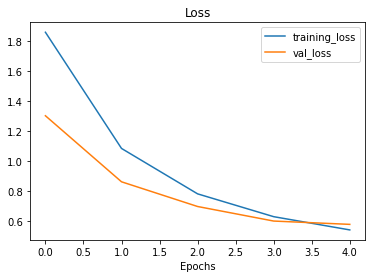

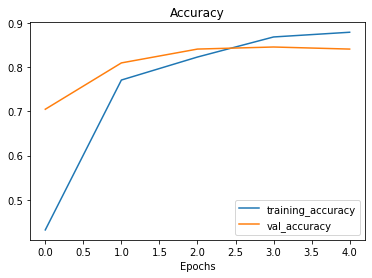

In [ ]:
# plotting the loss and accuracy curves:
plot_loss_curves(model_0_history)

**Understanding GlobalAveragePooling2D**

In [ ]:
# Average Pooling:
tf.random.set_seed(42)
input_shape = (1,4,4,3)
rand_tensor = tf.random.normal(input_shape)

print(f"input tensor {rand_tensor}")

avg_tensor = tf.keras.layers.GlobalAveragePooling2D()(rand_tensor)
print(f"Tensor after Avg Pooling: {avg_tensor}")

max_tensor = tf.keras.layers.GlobalMaxPooling2D()(rand_tensor)
print(f"Tensor after Max Pooling: {max_tensor}")

input tensor [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]
Tensor after Avg Pooling: [[-0.09368646 -0.45840448 -0.2885598 ]]
Tensor after Max Pooling: [[0.9058464 1.1603122 1.6994323]]


In [ ]:
tf.reduce_mean(rand_tensor, [1,2]).numpy() == avg_tensor

<tf.Tensor: shape=(1, 3), dtype=bool, numpy=array([[ True,  True,  True]])>

In [ ]:
tf.reduce_max(rand_tensor, [1,2]).numpy() == max_tensor

<tf.Tensor: shape=(1, 3), dtype=bool, numpy=array([[ True,  True,  True]])>

##Experiment Different Models:


1. model_1 : feature extraction on 1 % of data & data augmentation
2. model_2 : feature extraction on 10 % of data & data augmentation
3. model_3 : fine tuning on 10% of data & data augmentation
4. model_4 : fine tuning on 100% of data & data augmentation



In [ ]:
# 1- getting data:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2023-01-03 11:30:25--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.16.128, 142.251.45.16, 172.217.0.48, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.16.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   234MB/s    in 0.5s    

2023-01-03 11:30:26 (234 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [ ]:
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

In [ ]:
# create data batches:
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           batch_size=32, # default
                                                                           image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### Building data augmentation layer and visualize it:

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [ ]:
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2)
], name = "data_augmentation_layer")


**Visualizing un-augmented and augmented images**

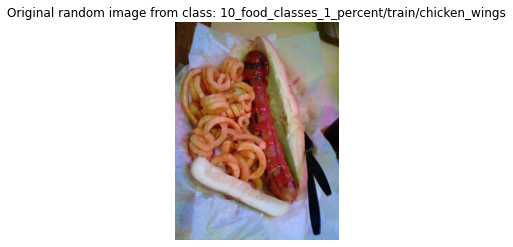

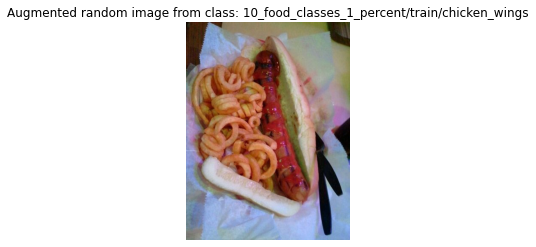

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

# get random class
random_class = random.choice(train_data_1_percent.class_names)
# build its path:
class_dir = "10_food_classes_1_percent/train/"+ random_class
# get random image:
random_image = random.choice(os.listdir(class_dir)) 
# get image's path:
image_path = class_dir + '/' + random_image
# transform the image as an numpy array
img = mpimg.imread(image_path)

plt.imshow(img)
plt.title(f"Original random image from class: {class_dir}")
plt.axis(False); # turn off the axes


# Displaying the Augmented version:
# image must be normalized after the augmentation layer
augmented_img = data_augmentation(tf.expand_dims(img, axis=0)) # data augmentation model requires shape (None, height, width, 3)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) # requires normalization after augmentation
plt.title(f"Augmented random image from class: {class_dir}")
plt.axis(False);

**Model_1**

In [ ]:
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

INPUT_SHAPE = (224,224,3)
inputs = tf.keras.layers.Input(shape = INPUT_SHAPE, name = "input_layer")

x = data_augmentation(inputs, training = False)  # passing inputs to the augmentation layer [sequential model], and don't train it
x = base_model(x)

x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)

outputs = tf.keras.layers.Dense(10, activation = 'softmax', name="output_layer")(x)

model_1 = tf.keras.Model(inputs, outputs)

In [ ]:
model_1.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

model_1_history = model_1.fit(train_data_1_percent,
                              epochs = 5,
                              steps_per_epoch = len(train_data_1_percent),
                              validation_data = test_data,
                              validation_steps = int(0.25 * len(test_data)))

Epoch 1/5
3/3 [==============================] - 10s 2s/step - loss: 2.3788 - accuracy: 0.1286 - val_loss: 2.2017 - val_accuracy: 0.1891
Epoch 2/5
3/3 [==============================] - 2s 992ms/step - loss: 2.0856 - accuracy: 0.2714 - val_loss: 2.0470 - val_accuracy: 0.2993
Epoch 3/5
3/3 [==============================] - 2s 1s/step - loss: 1.8278 - accuracy: 0.5143 - val_loss: 1.8873 - val_accuracy: 0.4227
Epoch 4/5
3/3 [==============================] - 2s 986ms/step - loss: 1.6233 - accuracy: 0.7000 - val_loss: 1.7625 - val_accuracy: 0.5082
Epoch 5/5
3/3 [==============================] - 3s 1s/step - loss: 1.4212 - accuracy: 0.8714 - val_loss: 1.6728 - val_accuracy: 0.5576


In [ ]:
# Evaluate on the test data
results_1_percent_data_aug = model_1.evaluate(test_data)

results_1_percent_data_aug

79/79 [==============================] - 7s 80ms/step - loss: 1.6747 - accuracy: 0.5744


[1.6747368574142456, 0.574400007724762]

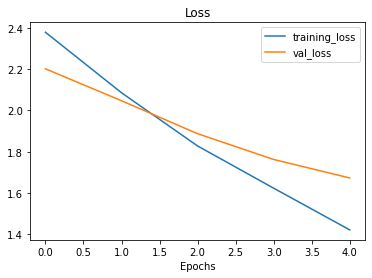

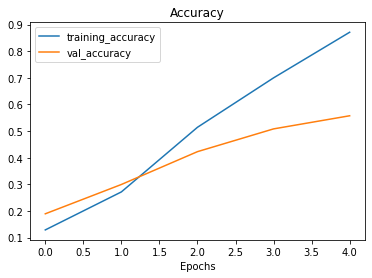

In [ ]:
plot_loss_curves(model_1_history)

**Model_2 : Feature extraction transfer learning with 10% of data and data augmentation**

In [ ]:
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

INPUT_SHAPE = (224,224,3)
inputs = tf.keras.layers.Input(shape = INPUT_SHAPE, name = "input_layer")

x = data_augmentation(inputs, training = False)  # passing inputs to the augmentation layer [sequential model], and don't train it
x = base_model(x)

x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)

outputs = tf.keras.layers.Dense(10, activation = 'softmax', name="output_layer")(x)

model_2 = tf.keras.Model(inputs, outputs)

In [ ]:
model_2.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

**CheckPointCallback**

In [ ]:
# define the path where the checkpoint callback will save its files at
checkpoint_path = 'ten_percent_model_checkpoints_weights/checkpoint.ckpt'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                         save_weights_only = True,
                                                         save_best_only = False,
                                                         save_frequency = 'epoch',
                                                         verbose = 1)

**fitting model_2 and use ModelCheckpoint callback within it.**

In [ ]:
model_2_history = model_2.fit(train_data_10_percent,
                              epochs = 5,
                              steps_per_epoch = len(train_data_10_percent),
                              validation_data = test_data,
                              validation_steps = int(0.25 * len(test_data)),
                              callbacks = [checkpoint_callback])

Epoch 1/5
23/24 [===========================>..] - ETA: 0s - loss: 1.8718 - accuracy: 0.4090
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 12s 235ms/step - loss: 1.8641 - accuracy: 0.4120 - val_loss: 1.2973 - val_accuracy: 0.7303
Epoch 2/5
23/24 [===========================>..] - ETA: 0s - loss: 1.0910 - accuracy: 0.7894
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 4s 169ms/step - loss: 1.0875 - accuracy: 0.7893 - val_loss: 0.8642 - val_accuracy: 0.8273
Epoch 3/5
23/24 [===========================>..] - ETA: 0s - loss: 0.7899 - accuracy: 0.8220
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 4s 167ms/step - loss: 0.7857 - accuracy: 0.8253 - val_loss: 0.6999 - val_accuracy: 0.8372
Epoch 4/5
23/24 [===========================>..] - ETA: 0s - loss: 0.6418 - accuracy: 0.85

In [ ]:
results_2_percent_data_aug = model_2.evaluate(test_data)
results_2_percent_data_aug

79/79 [==============================] - 7s 78ms/step - loss: 0.5535 - accuracy: 0.8644


[0.5535092353820801, 0.8644000291824341]

In [ ]:
model_0.evaluate(test_data)

79/79 [==============================] - 7s 77ms/step - loss: 0.5489 - accuracy: 0.8608


[0.5488659739494324, 0.86080002784729]

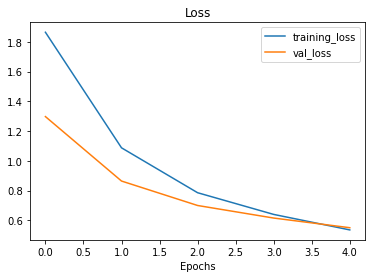

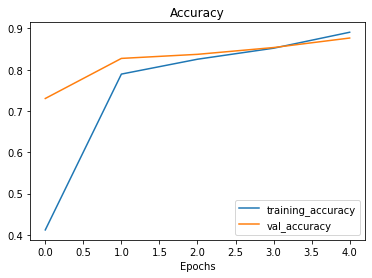

In [ ]:
plot_loss_curves(model_2_history)

**load saved weights and use it instead of model_2's existing weights and compare between both performance**

In [ ]:
model_2.load_weights(checkpoint_path)
loaded_weights_model_results = model_2.evaluate(test_data)

loaded_weights_model_results

79/79 [==============================] - 7s 78ms/step - loss: 0.5535 - accuracy: 0.8644


[0.5535093545913696, 0.8644000291824341]

In [ ]:
loaded_weights_model_results == results_2_percent_data_aug

False

if they were too close to each other but not equal, you can use numpy.isclose(np_arr1, np_arr2)

**Model_3: Fine-tuning an existing model on 10% of the data**

Un-Freezing the last 10 layers from model 2

In [ ]:
# model_3 is the same as model_2 but with further epochs
# model_2.layers
# for layer in model_2.layers:
#   print(layer.trainable)

print(len(model_2.layers[2].trainable_variables))

0


In [ ]:
# make all layers.trainable true and then exclude only the last 10 layers to be true
base_model.trainable = True
for layer in base_model.layers[:-10]:
   layer.trainable = False

In [ ]:
# for i, layer in enumerate(base_model.layers):
#   print(i,layer.name,layer.trainable )

print(len(model_2.layers[2].trainable_variables))

10


In [ ]:
print(len(model_2.trainable_variables))

12


In [ ]:
model_2.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
                metrics = ['accuracy'])

In [ ]:
# fine tuning model_2 for another 5-epochs (fitting the model):
tuning_epochs = 10 # 10 --- 5 for initial_epochs and 5 for further tuning
model_3_history = model_2.fit(train_data_10_percent,
                              epochs=tuning_epochs,
                              validation_data=test_data,
                              initial_epoch=model_2_history.epoch[-1], # start from previous last epoch
                              validation_steps=int(0.25 * len(test_data)))

Epoch 5/10
24/24 [==============================] - 13s 228ms/step - loss: 0.6025 - accuracy: 0.8600 - val_loss: 0.5030 - val_accuracy: 0.8553
Epoch 6/10
24/24 [==============================] - 4s 161ms/step - loss: 0.4492 - accuracy: 0.9120 - val_loss: 0.4525 - val_accuracy: 0.8618
Epoch 7/10
24/24 [==============================] - 4s 160ms/step - loss: 0.3859 - accuracy: 0.9187 - val_loss: 0.4313 - val_accuracy: 0.8734
Epoch 8/10
24/24 [==============================] - 4s 161ms/step - loss: 0.3317 - accuracy: 0.9293 - val_loss: 0.4410 - val_accuracy: 0.8651
Epoch 9/10
24/24 [==============================] - 4s 158ms/step - loss: 0.3029 - accuracy: 0.9480 - val_loss: 0.4281 - val_accuracy: 0.8668
Epoch 10/10
24/24 [==============================] - 4s 161ms/step - loss: 0.2506 - accuracy: 0.9573 - val_loss: 0.4021 - val_accuracy: 0.8849


In [ ]:
# Evaluate the model on the test data
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 7s 76ms/step - loss: 0.3806 - accuracy: 0.8852


In [ ]:
# Updating the plot_loss function to plot before and after fine tuning:
def compare_histories(original_history, new_history, initial_epochs = 5):
  acc = original_history.history["accuracy"]
  val_acc = original_history.history["val_accuracy"]

  loss = original_history.history["loss"]
  val_loss = original_history.history["val_loss"]

  total_acc = acc + new_history.history["accuracy"]
  total_val_acc = val_acc + new_history.history["val_accuracy"]

  total_loss = loss + new_history.history["loss"]
  total_val_loss = val_loss + new_history.history["val_loss"]

   # Make plots
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label='Training Accuracy')
  plt.plot(total_val_acc, label='Validation Accuracy')
  plt.plot([initial_epochs-1, initial_epochs-1],
            plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(total_loss, label='Training Loss')
  plt.plot(total_val_loss, label='Validation Loss')
  plt.plot([initial_epochs-1, initial_epochs-1],
            plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

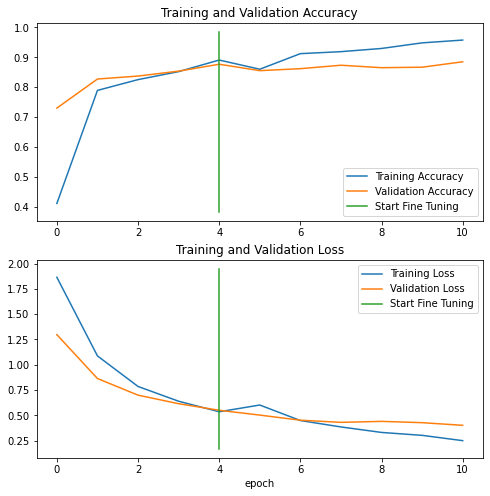

In [ ]:
compare_histories(original_history=model_2_history, 
                 new_history=model_3_history, 
                 initial_epochs=5)

**Model_3: Same as model_2 but with more data**